## Import Libraries and Understand the Data

In [ ]:
%%capture
%pip install scikit-learn pandas numpy matplotlib tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (SimpleRNN, LSTM, Dense, Layer, Dropout, Multiply,
                                     Lambda, Input, Add, LayerNormalization, Concatenate,
                                     Bidirectional)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Data Preprocessing

## Load and Clean FRED-MD and Wheat Futures Data

### Load the FRED-MD Macroeconomic Dataset

In [ ]:
macro_df = pd.read_csv("data/FRED_MD.csv")
macro_df.head()

### Clean FRED-MD Dates and Remove Metadata Rows

In [ ]:
macro_df["sasdate"] = pd.to_datetime(macro_df["sasdate"], errors="coerce")
macro_df = macro_df.dropna(subset=["sasdate"])
macro_df = macro_df.set_index("sasdate").sort_index()
macro_df.head()

### Load the Wheat Futures Dataset

In [ ]:
wheat_train = pd.read_csv("data/wheat_prices_train.csv")
wheat_val = pd.read_csv("data/wheat_prices_val.csv")
wheat_test = pd.read_csv("data/wheat_prices_test.csv")
wheat_train.shape, wheat_val.shape, wheat_test.shape

### Calculate Log Returns

In [ ]:
for df in [wheat_train, wheat_val, wheat_test]:
    df["Price"] = (
        df["Price"]
        .astype(str)
        .str.replace(",", "")
    )
    df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
    df["LogReturn"] = np.log(df["Price"]).diff()

wheat_train["LogReturn"] = np.log(wheat_train["Price"]).diff()
wheat_val["LogReturn"] = np.log(wheat_val["Price"]).diff()
wheat_test["LogReturn"] = np.log(wheat_test["Price"]).diff()

wheat_train = wheat_train.set_index("Date").sort_index()
wheat_val = wheat_val.set_index("Date").sort_index()
wheat_test = wheat_test.set_index("Date").sort_index()

wheat_train.head()

## Resampling

Macroeconomic data does not lose relevance instantly after release.  
Instead, its influence **decays gradually over time**.

So, we use **decay-weighted resampling**, where macroeconomic signals fade smoothly rather than changing abruptly.



### Resample Macro Data to Daily Frequency

In [ ]:
macro_daily = macro_df.resample("D").ffill()
macro_daily.shape

### Detect Release Events Per Column

In [ ]:
release_mask = macro_daily.ne(macro_daily.shift(1))
release_mask.head()

### Compute Days Since Last Release

In [ ]:
days_since_release = release_mask.cumsum()
days_since_release = days_since_release.apply(lambda x: x.groupby(x).cumcount())
days_since_release.head()

### Apply Decay-Weighted Forward Fill

In [ ]:
decay_rate = 0.02
decay_factors = np.exp(-decay_rate * days_since_release)
macro_decay = macro_daily * decay_factors
macro_decay.head()

In [ ]:
macro_df = macro_decay.reset_index()
macro_df = macro_df.rename(columns={"sasdate": "Date"})
macro_df["Date"] = macro_df["Date"].dt.strftime("%m/%d/%Y")
macro_df = macro_df.set_index("Date").sort_index()
macro_df.head()

In [ ]:
selected_features = [
    "RPI", "W875RX1", "CMRMTSPLx", "IPFPNSS", "USWTRADE", "USTRADE", "BUSLOANS", "CONSPI", "S&P 500", "S&P PE ratio",
    "FEDFUNDS", "TB3MS", "TB6MS", "GS1", "GS5", "GS10", "AAA", "BAA", "TB3SMFFM", "TB6SMFFM", "T1YFFM", "T5YFFM", "T10YFFM",
    "AAAFFM", "BAAFFM", "EXSZUSx", "EXJPUSx", "EXUSUKx", "EXCAUSx", "PPICMM", "UMCSENTx"
]

macro_df = macro_df[selected_features]
macro_df.head()

In [ ]:
train_merged = wheat_train[["LogReturn"]].join(macro_df, how="inner").dropna()
val_merged = wheat_val[["LogReturn"]].join(macro_df, how="inner").dropna()
test_merged = wheat_test[["LogReturn"]].join(macro_df, how="inner").dropna()

print(f"Train Merged: {train_merged.shape}")
print(f"Val Merged:   {val_merged.shape}")
print(f"Test Merged:  {test_merged.shape}")

## Data Preparation 

In [ ]:
train_merged.info()

### Standard Scaling

In [ ]:
target_col = "LogReturn"
feature_cols = [c for c in train_merged.columns if c != target_col]

X_train = train_merged[feature_cols].values
y_train = train_merged[target_col].values

X_val = val_merged[feature_cols].values
y_val = val_merged[target_col].values

X_test = test_merged[feature_cols].values
y_test = test_merged[target_col].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()
print(f"Target scaled - Train mean: {y_train_scaled.mean():.4f}, std: {y_train_scaled.std():.4f}")

### Create 30-Day Lookback Sequences

Transform data into sliding window sequences of shape `(samples, 30, features)` for temporal neural networks.

In [ ]:
def create_sequences(X_data, y_data, lookback=30):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - lookback):
        X_seq.append(X_data[i:i+lookback])
        y_seq.append(y_data[i+lookback])
    return np.array(X_seq), np.array(y_seq)

SEQ_LENGTH = 30

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQ_LENGTH)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, SEQ_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, SEQ_LENGTH)

print(f"Train: {X_train_seq.shape}, Val: {X_val_seq.shape}, Test: {X_test_seq.shape}")

### 5-Fold Time Series Cross-Validation

For hyperparameter tuning and model selection, implement 5-fold CV within the training set while preserving temporal order.

# Recurrent Neural Network (RNN)

In [ ]:
X_train_seq.shape, y_train_seq.shape

## RNN Baseline Model

In [ ]:
model = Sequential([
    SimpleRNN(
        units=128,
        activation="tanh",
        return_sequences=False,
        recurrent_dropout=0.2,
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss="mse"
)

### Model Training


In [ ]:
history = model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20,
    batch_size=32,
    verbose=1
)
test_loss = model.evaluate(X_test_seq, y_test_seq)
test_loss

### Evaluate RNN

In [ ]:
y_pred_scaled = model.predict(X_test_seq).flatten()

y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print(f"MSE:  {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE:  {mae:.6f}")

mse, rmse, mae

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(range(len(y_true)), y_true, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred)), y_pred, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'Baseline RNN: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## RNN with Attention Mechanism

Attention allows the model to focus on specific time steps that are most relevant for prediction, rather than relying solely on the final hidden state.

In [ ]:
class AttentionLayer(Layer):
    
    def __init__(self, return_attention=False, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.return_attention = return_attention
    
    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        self.u = self.add_weight(
            name='attention_context',
            shape=(input_shape[-1],),
            initializer='glorot_uniform',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=1), axis=1)
        attention_weights = tf.expand_dims(attention_weights, -1)
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)
        
        if self.return_attention:
            return attention_weights
        return context_vector
    
    def get_config(self):
        config = super(AttentionLayer, self).get_config()
        config.update({'return_attention': self.return_attention})
        return config

### Build RNN with Attention Model

In [ ]:
def build_rnn_attention_model(seq_length, n_features, rnn_units=128, dropout_rate=0.2):
    inputs = Input(shape=(seq_length, n_features))
    rnn_out = SimpleRNN(
        units=rnn_units,
        activation='tanh',
        return_sequences=True,
        recurrent_dropout=dropout_rate
    )(inputs)
    
    context_vector = AttentionLayer(return_attention=False)(rnn_out)
    x = Dropout(dropout_rate)(context_vector)  
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


rnn_attention_model = build_rnn_attention_model(
    seq_length=X_train_seq.shape[1],
    n_features=X_train_seq.shape[2],
    rnn_units=128,
    dropout_rate=0.2
)

rnn_attention_model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='mse'
)

rnn_attention_model.summary()

### Train RNN with Attention

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history_attention = rnn_attention_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

### Evaluate RNN with Attention

In [ ]:
y_pred_attention_scaled = rnn_attention_model.predict(X_test_seq).flatten()

y_pred_attention = target_scaler.inverse_transform(y_pred_attention_scaled.reshape(-1, 1)).flatten()
y_true_attention = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_att = mean_squared_error(y_true_attention, y_pred_attention)
rmse_att = np.sqrt(mse_att)
mae_att = mean_absolute_error(y_true_attention, y_pred_attention)

print(f"MSE:  {mse_att:.6f}")
print(f"RMSE: {rmse_att:.6f}")
print(f"MAE:  {mae_att:.6f}")

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(range(len(y_true_attention)), y_true_attention, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_attention)), y_pred_attention, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'RNN with Attention: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## RNN with Attention and Skip Connections

In [ ]:
class AttentionLayer(Layer):
    
    def __init__(self, return_attention=False, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.return_attention = return_attention
    
    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        self.u = self.add_weight(
            name='attention_context',
            shape=(input_shape[-1],),
            initializer='glorot_uniform',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=1), axis=1)
        attention_weights = tf.expand_dims(attention_weights, -1)
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)
        
        if self.return_attention:
            return attention_weights
        return context_vector
    
    def get_config(self):
        config = super(AttentionLayer, self).get_config()
        config.update({'return_attention': self.return_attention})
        return config

### Build Model with Skip Connections

In [ ]:
def build_rnn_attention_skip_model(seq_length, n_features, rnn_units=64, dropout_rate=0.3):
    
    inputs = Input(shape=(seq_length, n_features))
    rnn_out = SimpleRNN(
        units=rnn_units,
        activation='tanh',
        return_sequences=True,
        recurrent_dropout=dropout_rate,
        kernel_regularizer=l2(1e-4),
        recurrent_regularizer=l2(1e-4)
    )(inputs)
    
    context_vector = AttentionLayer(return_attention=False)(rnn_out)
    last_hidden = rnn_out[:, -1, :]
    gate_input = Concatenate()([context_vector, last_hidden])
    gate = Dense(rnn_units, activation='sigmoid')(gate_input)
    gated_context = Multiply()([context_vector, Lambda(lambda x: 1.0 - x)(gate)])
    gated_residual = Multiply()([last_hidden, gate])
    
    combined = Add()([gated_context, gated_residual])
    skip_connection_output = LayerNormalization()(combined)
    
    x = Dropout(dropout_rate)(skip_connection_output)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


rnn_attention_skip_model = build_rnn_attention_skip_model(
    seq_length=X_train_seq.shape[1],
    n_features=X_train_seq.shape[2],
    rnn_units=64, 
    dropout_rate=0.3
)

rnn_attention_skip_model.compile(
    optimizer=Adam(learning_rate=1e-4), # Reduced from 5e-4
    loss='mse'
)

rnn_attention_skip_model.summary()



### Train Model

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history_skip = rnn_attention_skip_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

### Evaluate Model

In [ ]:
y_pred_skip_scaled = rnn_attention_skip_model.predict(X_test_seq).flatten()

y_pred_skip = target_scaler.inverse_transform(y_pred_skip_scaled.reshape(-1, 1)).flatten()
y_true_skip = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_skip = mean_squared_error(y_true_skip, y_pred_skip)
rmse_skip = np.sqrt(mse_skip)
mae_skip = mean_absolute_error(y_true_skip, y_pred_skip)

print(f"MSE:  {mse_skip:.6f}")
print(f"RMSE: {rmse_skip:.6f}")
print(f"MAE:  {mae_skip:.6f}")

### RNN Model Comparison Graph

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
models = ['RNN', 'RNN + Attention', 'RNN + Attention + Skip']
rmse_scores = [rmse, rmse_att, rmse_skip]
mae_scores = [mae, mae_att, mae_skip]

x = np.arange(len(models))
width = 0.35

rects1 = ax.bar(x - width/2, rmse_scores, width, label='RMSE', color='#2E86AB')
rects2 = ax.bar(x + width/2, mae_scores, width, label='MAE', color='#E94F37')

ax.set_ylabel('Scores')
ax.set_title('RNN Models Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()

### RNN Loss Comparison Graph

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(history.history['val_loss'], label='RNN', linestyle='--', color='#2E86AB')
ax.plot(history_attention.history['val_loss'], label='RNN + Att', linestyle='-', color='#E94F37')
ax.plot(history_skip.history['val_loss'], label='RNN + Att + Skip', linestyle='-.', color='#45B7D1')

ax.set_ylabel('Val Loss (MSE)')
ax.set_xlabel('Epochs')
ax.set_title('RNN Models Validation Loss Comparison')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(range(len(y_true_skip)), y_true_skip, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_skip)), y_pred_skip, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'RNN with Attention + Skip Connections: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Bidirectional Recurrent Neural Network (BiRNN)

## Bidirectional RNN Baseline Model

In [ ]:
bidir_model = Sequential([
    Bidirectional(
        SimpleRNN(
            units=128,
            activation="tanh",
            return_sequences=False,
            recurrent_dropout=0.2
        ),
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ),
    Dense(1)
])

bidir_model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss="mse"
)

### Model Training

In [ ]:
history_bidir = bidir_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20,
    batch_size=32,
    verbose=1
)
test_loss_bidir = bidir_model.evaluate(X_test_seq, y_test_seq)
test_loss_bidir

### Evaluate Bidirectional RNN

In [ ]:
y_pred_bidir_scaled = bidir_model.predict(X_test_seq).flatten()

y_pred_bidir = target_scaler.inverse_transform(y_pred_bidir_scaled.reshape(-1, 1)).flatten()
y_true_bidir = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_bidir = mean_squared_error(y_true_bidir, y_pred_bidir)
rmse_bidir = np.sqrt(mse_bidir)
mae_bidir = mean_absolute_error(y_true_bidir, y_pred_bidir)

print(f"MSE:  {mse_bidir:.6f}")
print(f"RMSE: {rmse_bidir:.6f}")
print(f"MAE:  {mae_bidir:.6f}")

mse_bidir, rmse_bidir, mae_bidir

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(range(len(y_true_bidir)), y_true_bidir, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_bidir)), y_pred_bidir, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'Bidirectional RNN: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## Bidirectional RNN with Attention Mechanism

Wrapping the RNN in a Bidirectional layer lets the model capture both past and future context at every time step, while attention selectively weights the most informative positions.

In [ ]:
class BiDirAttentionLayer(Layer):

    def __init__(self, return_attention=False, **kwargs):
        super(BiDirAttentionLayer, self).__init__(**kwargs)
        self.return_attention = return_attention

    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        self.u = self.add_weight(
            name='attention_context',
            shape=(input_shape[-1],),
            initializer='glorot_uniform',
            trainable=True
        )
        super(BiDirAttentionLayer, self).build(input_shape)

    def call(self, inputs):
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=1), axis=1)
        attention_weights = tf.expand_dims(attention_weights, -1)
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)

        if self.return_attention:
            return attention_weights
        return context_vector

    def get_config(self):
        config = super(BiDirAttentionLayer, self).get_config()
        config.update({'return_attention': self.return_attention})
        return config

### Build Bidirectional RNN with Attention Model

In [ ]:
def build_bidir_rnn_attention_model(seq_length, n_features, rnn_units=128, dropout_rate=0.2):
    inputs = Input(shape=(seq_length, n_features))
    rnn_out = Bidirectional(
        SimpleRNN(
            units=rnn_units,
            activation='tanh',
            return_sequences=True,
            recurrent_dropout=dropout_rate
        )
    )(inputs)

    context_vector = BiDirAttentionLayer(return_attention=False)(rnn_out)
    x = Dropout(dropout_rate)(context_vector)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


bidir_rnn_attention_model = build_bidir_rnn_attention_model(
    seq_length=X_train_seq.shape[1],
    n_features=X_train_seq.shape[2],
    rnn_units=128,
    dropout_rate=0.2
)

bidir_rnn_attention_model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='mse'
)

bidir_rnn_attention_model.summary()

### Train Bidirectional RNN with Attention

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history_bidir_attention = bidir_rnn_attention_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

### Evaluate Bidirectional RNN with Attention

In [ ]:
y_pred_bidir_att_scaled = bidir_rnn_attention_model.predict(X_test_seq).flatten()

y_pred_bidir_att = target_scaler.inverse_transform(y_pred_bidir_att_scaled.reshape(-1, 1)).flatten()
y_true_bidir_att = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_bidir_att = mean_squared_error(y_true_bidir_att, y_pred_bidir_att)
rmse_bidir_att = np.sqrt(mse_bidir_att)
mae_bidir_att = mean_absolute_error(y_true_bidir_att, y_pred_bidir_att)

print(f"MSE:  {mse_bidir_att:.6f}")
print(f"RMSE: {rmse_bidir_att:.6f}")
print(f"MAE:  {mae_bidir_att:.6f}")

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(range(len(y_true_bidir_att)), y_true_bidir_att, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_bidir_att)), y_pred_bidir_att, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'Bidirectional RNN with Attention: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## Bidirectional RNN with Attention and Skip Connections

In [ ]:
class BiDirAttentionLayerSkip(Layer):

    def __init__(self, return_attention=False, **kwargs):
        super(BiDirAttentionLayerSkip, self).__init__(**kwargs)
        self.return_attention = return_attention

    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        self.u = self.add_weight(
            name='attention_context',
            shape=(input_shape[-1],),
            initializer='glorot_uniform',
            trainable=True
        )
        super(BiDirAttentionLayerSkip, self).build(input_shape)

    def call(self, inputs):
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=1), axis=1)
        attention_weights = tf.expand_dims(attention_weights, -1)
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)

        if self.return_attention:
            return attention_weights
        return context_vector

    def get_config(self):
        config = super(BiDirAttentionLayerSkip, self).get_config()
        config.update({'return_attention': self.return_attention})
        return config

### Build Model with Skip Connections

In [ ]:
def build_bidir_rnn_attention_skip_model(seq_length, n_features, rnn_units=64, dropout_rate=0.3):

    inputs = Input(shape=(seq_length, n_features))
    rnn_out = Bidirectional(
        SimpleRNN(
            units=rnn_units,
            return_sequences=True,
            recurrent_dropout=dropout_rate,
            kernel_regularizer=l2(1e-4),
            recurrent_regularizer=l2(1e-4)
        )
    )(inputs)

    context_vector = BiDirAttentionLayerSkip(return_attention=False)(rnn_out)
    last_hidden = rnn_out[:, -1, :]
    gate_input = Concatenate()([context_vector, last_hidden])
    gate = Dense(rnn_units * 2, activation='sigmoid')(gate_input)
    gated_context = Multiply()([context_vector, Lambda(lambda x: 1.0 - x)(gate)])
    gated_residual = Multiply()([last_hidden, gate])

    combined = Add()([gated_context, gated_residual])
    skip_connection_output = LayerNormalization()(combined)

    x = Dropout(dropout_rate)(skip_connection_output)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


bidir_rnn_attention_skip_model = build_bidir_rnn_attention_skip_model(
    seq_length=X_train_seq.shape[1],
    n_features=X_train_seq.shape[2],
    rnn_units=64,
    dropout_rate=0.3
)

bidir_rnn_attention_skip_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='mse'
)

bidir_rnn_attention_skip_model.summary()

### Train Model

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history_bidir_skip = bidir_rnn_attention_skip_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)

### Evaluate Model

In [ ]:
y_pred_bidir_skip_scaled = bidir_rnn_attention_skip_model.predict(X_test_seq).flatten()

y_pred_bidir_skip = target_scaler.inverse_transform(y_pred_bidir_skip_scaled.reshape(-1, 1)).flatten()
y_true_bidir_skip = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_bidir_skip = mean_squared_error(y_true_bidir_skip, y_pred_bidir_skip)
rmse_bidir_skip = np.sqrt(mse_bidir_skip)
mae_bidir_skip = mean_absolute_error(y_true_bidir_skip, y_pred_bidir_skip)

print(f"MSE:  {mse_bidir_skip:.6f}")
print(f"RMSE: {rmse_bidir_skip:.6f}")
print(f"MAE:  {mae_bidir_skip:.6f}")

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(range(len(y_true_bidir_skip)), y_true_bidir_skip, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_bidir_skip)), y_pred_bidir_skip, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'Bidirectional RNN with Attention + Skip Connections: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

### Bi-Directional RNN Model Comparison Graph

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
models = ['BiRNN', 'BiRNN + Attention', 'BiRNN + Attention + Skip']
rmse_scores = [rmse_bidir, rmse_bidir_att, rmse_bidir_skip]
mae_scores = [mae_bidir, mae_bidir_att, mae_bidir_skip]

x = np.arange(len(models))
width = 0.35

rects1 = ax.bar(x - width/2, rmse_scores, width, label='RMSE', color='#2E86AB')
rects2 = ax.bar(x + width/2, mae_scores, width, label='MAE', color='#E94F37')

ax.set_ylabel('Scores')
ax.set_title('Bi-Directional RNN Models Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()

### Bi-Directional RNN Loss Comparison Graph

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(history_bidir.history['val_loss'], label='BiRNN', linestyle='--', color='#2E86AB')
ax.plot(history_bidir_attention.history['val_loss'], label='BiRNN + Att', linestyle='-', color='#E94F37')
ax.plot(history_bidir_skip.history['val_loss'], label='BiRNN + Att + Skip', linestyle='-.', color='#45B7D1')

ax.set_ylabel('Val Loss (MSE)')
ax.set_xlabel('Epochs')
ax.set_title('Bi-Directional RNN Models Validation Loss Comparison')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(range(len(y_true_bidir_skip)), y_true_bidir_skip, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_bidir_skip)), y_pred_bidir_skip, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'Bidirectional RNN with Attention + Skip Connections: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## Long Short-Term Memory (LSTM)

### LSTM Baseline Model

In [ ]:
lstm_model = Sequential([
    LSTM(
        units=128,
        activation="tanh",
        return_sequences=False,
        recurrent_dropout=0.2,
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ),
    Dense(1)
])

lstm_model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss="mse"
)

lstm_model.summary()

### Model Training

In [89]:
history_lstm = lstm_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20,
    batch_size=32,
    verbose=1
)

127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - loss: 1.0086 - val_loss: 0.8256
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - loss: 1.0066 - val_loss: 0.8165
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 1.0014 - val_loss: 0.8008
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 1.0018 - val_loss: 0.7980
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - loss: 0.9992 - val_loss: 0.8035
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - loss: 0.9927 - val_loss: 0.7967
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.9951 - val_loss: 0.7964
Epoch 9/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - loss: 0.9914 - val_loss: 0.8125
Epoch 10/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - loss: 0.9948 - val_loss: 0.7986
Epoch 11/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 0.9895 - val_loss: 0.7961
Epoch 12/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - loss: 0.9842 - val_loss: 0.8010
Epoch 13/20
127/127 ━━━━━━━━━━━━

### Evaluate LSTM

In [90]:
y_pred_lstm_scaled = lstm_model.predict(X_test_seq).flatten()

y_pred_lstm = target_scaler.inverse_transform(y_pred_lstm_scaled.reshape(-1, 1)).flatten()
y_true_lstm = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_lstm = mean_squared_error(y_true_lstm, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_true_lstm, y_pred_lstm)

print(f"MSE:  {mse_lstm:.6f}")
print(f"RMSE: {rmse_lstm:.6f}")
print(f"MAE:  {mae_lstm:.6f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
MSE:  0.000250
RMSE: 0.015813
MAE:  0.011915


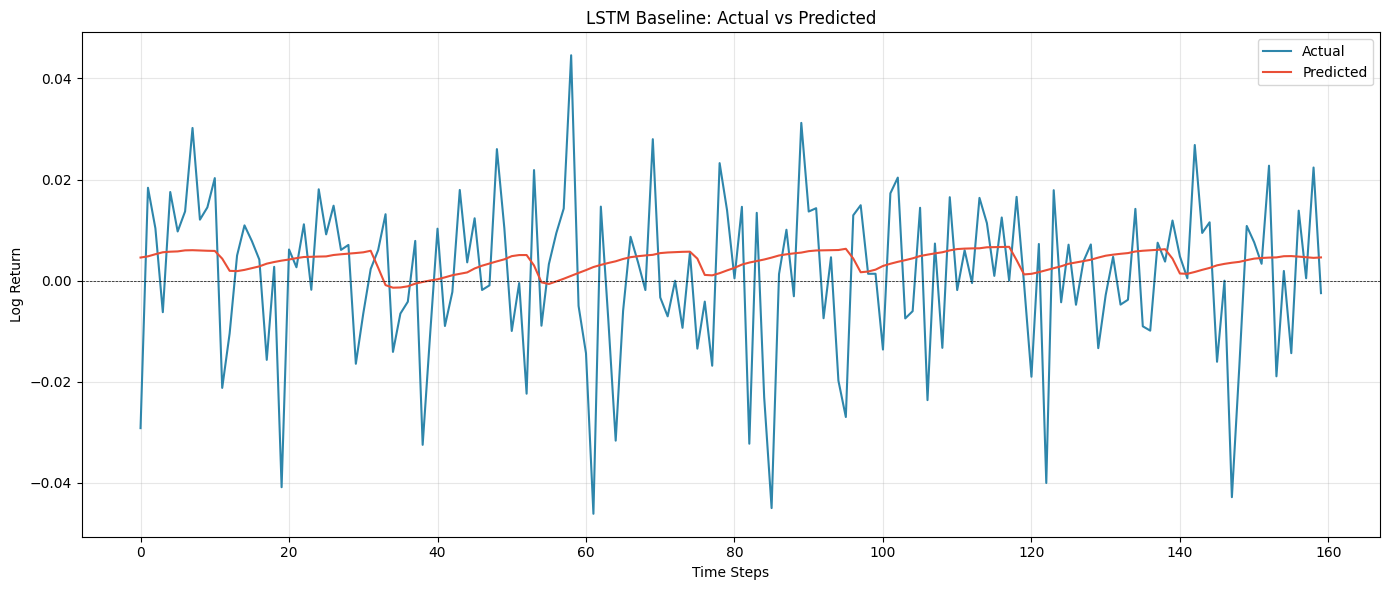

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(range(len(y_true_lstm)), y_true_lstm, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_lstm)), y_pred_lstm, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'LSTM Baseline: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

### LSTM with Attention Mechanism

In [92]:
def build_lstm_attention_model(seq_length, n_features, lstm_units=128, dropout_rate=0.2):
    inputs = Input(shape=(seq_length, n_features))
    lstm_out = LSTM(
        units=lstm_units,
        activation='tanh',
        return_sequences=True,
        recurrent_dropout=dropout_rate
    )(inputs)

    context_vector = AttentionLayer(return_attention=False)(lstm_out)
    x = Dropout(dropout_rate)(context_vector)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

### Build LSTM with Attention Model

In [93]:
lstm_attention_model = build_lstm_attention_model(
    seq_length=X_train_seq.shape[1],
    n_features=X_train_seq.shape[2]
)

lstm_attention_model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss="mse"
)

lstm_attention_model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 30, 31)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 30, 128)        │        81,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_6               │ (None, 128)            │        16,640 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,689 (385.50 KB)

 Trainable params: 98,689 (385.50 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [94]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history_lstm_att = lstm_attention_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - loss: 1.0222 - val_loss: 0.8494 - learning_rate: 5.0000e-04
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - loss: 1.0054 - val_loss: 0.8859 - learning_rate: 5.0000e-04
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - loss: 1.0130 - val_loss: 0.8555 - learning_rate: 5.0000e-04
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - loss: 1.0025 - val_loss: 0.8355 - learning_rate: 5.0000e-04
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - loss: 1.0087 - val_loss: 0.8758 - learning_rate: 5.0000e-04
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - loss: 1.0018 - val_loss: 0.8713 - learning_rate: 5.0000e-04
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - loss: 1.0048 - val_loss: 0.8842 - learning_rate: 5.0000e-04
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - loss: 1.0017 - val_loss: 0.8702 - learning_rate: 5.0000e-04
Epoch 9/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.

### Evaluate Model

In [95]:
y_pred_lstm_att_scaled = lstm_attention_model.predict(X_test_seq).flatten()

y_pred_lstm_att = target_scaler.inverse_transform(y_pred_lstm_att_scaled.reshape(-1, 1)).flatten()
y_true_lstm_att = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_lstm_att = mean_squared_error(y_true_lstm_att, y_pred_lstm_att)
rmse_lstm_att = np.sqrt(mse_lstm_att)
mae_lstm_att = mean_absolute_error(y_true_lstm_att, y_pred_lstm_att)

print(f"MSE:  {mse_lstm_att:.6f}")
print(f"RMSE: {rmse_lstm_att:.6f}")
print(f"MAE:  {mae_lstm_att:.6f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
MSE:  0.000242
RMSE: 0.015571
MAE:  0.011968


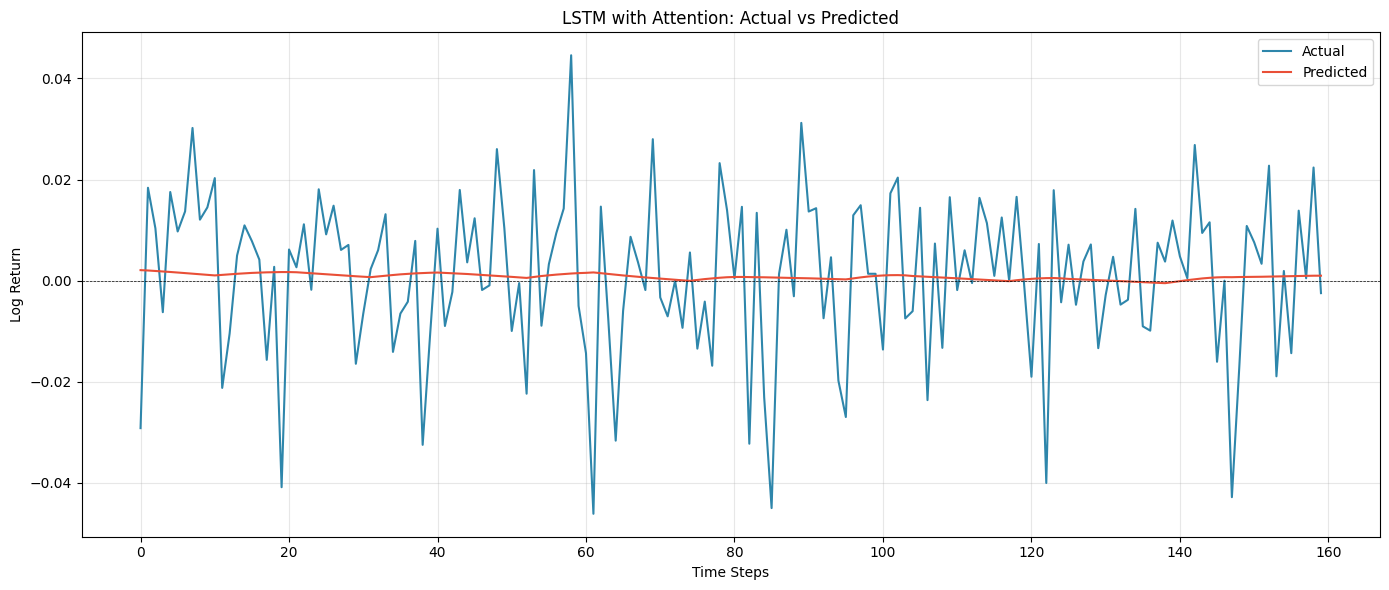

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(range(len(y_true_lstm_att)), y_true_lstm_att, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_lstm_att)), y_pred_lstm_att, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'LSTM with Attention: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

### LSTM with Attention + Skip Connections

In [97]:
def build_lstm_attention_skip_model(seq_length, n_features, lstm_units=64, dropout_rate=0.3):
    inputs = Input(shape=(seq_length, n_features))
    lstm_out = LSTM(
        units=lstm_units,
        activation='tanh',
        return_sequences=True,
        recurrent_dropout=dropout_rate,
        kernel_regularizer=l2(1e-4),
        recurrent_regularizer=l2(1e-4)
    )(inputs)

    context_vector = AttentionLayer(return_attention=False)(lstm_out)
    last_hidden = lstm_out[:, -1, :]
    gate_input = Concatenate()([context_vector, last_hidden])
    gate = Dense(lstm_units, activation='sigmoid')(gate_input)
    gated_context = Multiply()([context_vector, Lambda(lambda x: 1.0 - x)(gate)])
    gated_residual = Multiply()([last_hidden, gate])

    combined = Add()([gated_context, gated_residual])
    skip_connection_output = LayerNormalization()(combined)

    x = Dropout(dropout_rate)(skip_connection_output)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

### Build LSTM with Attention + Skip Model

In [98]:
lstm_attention_skip_model = build_lstm_attention_skip_model(
    seq_length=X_train_seq.shape[1],
    n_features=X_train_seq.shape[2]
)

lstm_attention_skip_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="mse"
)

lstm_attention_skip_model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 30, 31)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 30, 64)    │     24,576 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_7   │ (None, 64)        │      4,224 │ lstm_8[0][0]      │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 64)        │          0 │ lstm_8[0][0]      │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 128)       │          0 │ attention_layer_… │
│ (Concatenate)       │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 64)        │      8,256 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 64)        │          0 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_10         │ (None, 64)        │          0 │ attention_layer_… │
│ (Multiply)          │                   │            │ lambda_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_11         │ (None, 64)        │          0 │ get_item_5[0][0], │
│ (Multiply)          │                   │            │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 64)        │          0 │ multiply_10[0][0… │
│                     │                   │            │ multiply_11[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 64)        │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 32)        │      2,080 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 32)        │          0 │ dense_28[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 1)         │         33 │ dropout_19[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 39,297 (153.50 KB)

 Trainable params: 39,297 (153.50 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [99]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history_lstm_skip = lstm_attention_skip_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 2.1787 - val_loss: 0.8726 - learning_rate: 1.0000e-04
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 1.5551 - val_loss: 0.8581 - learning_rate: 1.0000e-04
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 1.3516 - val_loss: 0.8452 - learning_rate: 1.0000e-04
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 1.2314 - val_loss: 0.8393 - learning_rate: 1.0000e-04
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 1.1927 - val_loss: 0.8415 - learning_rate: 1.0000e-04
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 1.1456 - val_loss: 0.8410 - learning_rate: 1.0000e-04
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 1.1116 - val_loss: 0.8367 - learning_rate: 1.0000e-04
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 1.1098 - val_loss: 0.8376 - learning_rate: 1.0000e-04
Epoch 9/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 1.0836 - val_loss

### Evaluate Model

In [100]:
y_pred_lstm_skip_scaled = lstm_attention_skip_model.predict(X_test_seq).flatten()

y_pred_lstm_skip = target_scaler.inverse_transform(y_pred_lstm_skip_scaled.reshape(-1, 1)).flatten()
y_true_lstm_skip = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_lstm_skip = mean_squared_error(y_true_lstm_skip, y_pred_lstm_skip)
rmse_lstm_skip = np.sqrt(mse_lstm_skip)
mae_lstm_skip = mean_absolute_error(y_true_lstm_skip, y_pred_lstm_skip)

print(f"MSE:  {mse_lstm_skip:.6f}")
print(f"RMSE: {rmse_lstm_skip:.6f}")
print(f"MAE:  {mae_lstm_skip:.6f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
MSE:  0.000267
RMSE: 0.016341
MAE:  0.012896


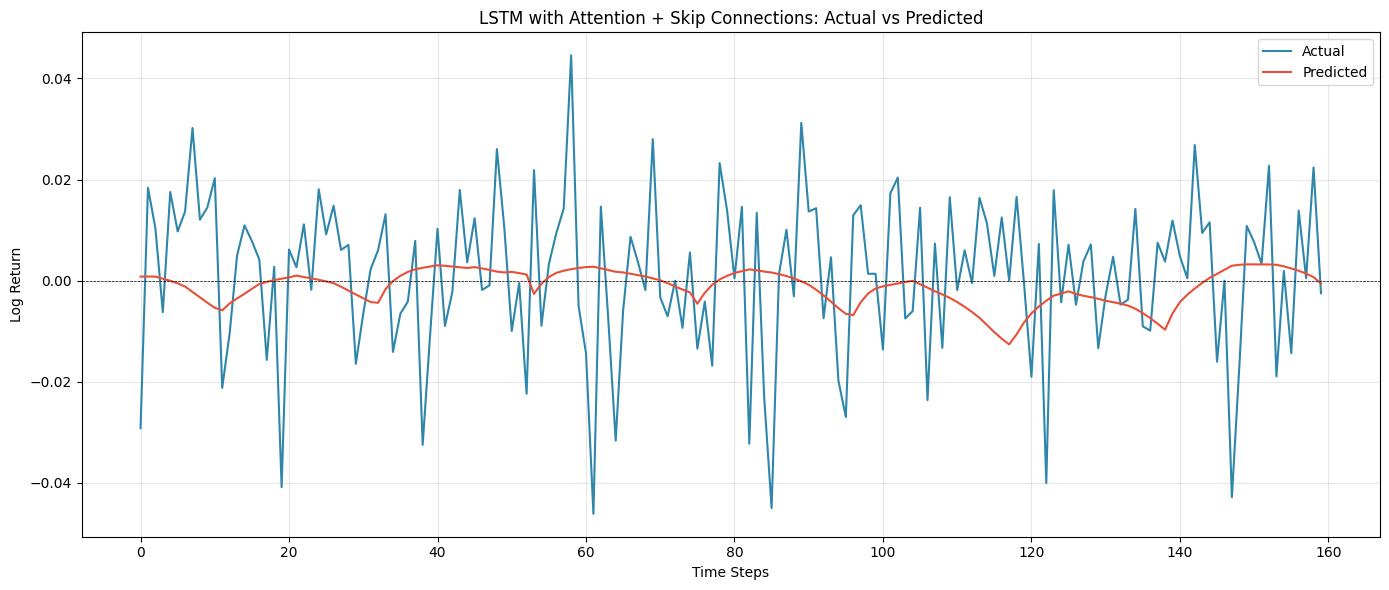

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(range(len(y_true_lstm_skip)), y_true_lstm_skip, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_lstm_skip)), y_pred_lstm_skip, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'LSTM with Attention + Skip Connections: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

### Error Metrics Comparison (RNN vs BiRNN vs LSTM)

                   Model      MSE     RMSE      MAE
            Baseline RNN 0.000634 0.025181 0.022064
         RNN + Attention 0.000637 0.025243 0.022136
  RNN + Attention + Skip 0.000242 0.015572 0.011941
                   BiRNN 0.000322 0.017947 0.014489
       BiRNN + Attention 0.000274 0.016548 0.012294
BiRNN + Attention + Skip 0.000636 0.025216 0.022051
                    LSTM 0.000250 0.015813 0.011915
        LSTM + Attention 0.000242 0.015571 0.011968
 LSTM + Attention + Skip 0.000267 0.016341 0.012896


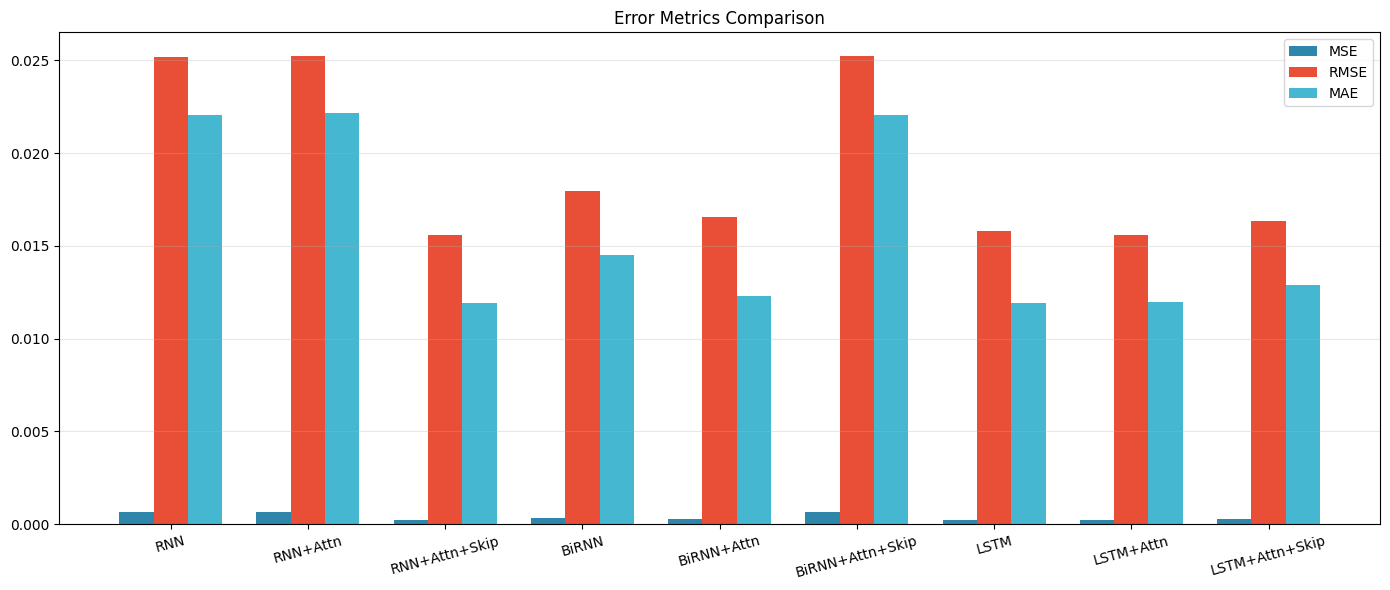

In [102]:
comparison_df = pd.DataFrame({
    'Model': ['Baseline RNN', 'RNN + Attention', 'RNN + Attention + Skip',
              'BiRNN', 'BiRNN + Attention', 'BiRNN + Attention + Skip',
              'LSTM', 'LSTM + Attention', 'LSTM + Attention + Skip'],
    'MSE': [mse, mse_att, mse_skip, mse_bidir, mse_bidir_att, mse_bidir_skip,
            mse_lstm, mse_lstm_att, mse_lstm_skip],
    'RMSE': [rmse, rmse_att, rmse_skip, rmse_bidir, rmse_bidir_att, rmse_bidir_skip,
             rmse_lstm, rmse_lstm_att, rmse_lstm_skip],
    'MAE': [mae, mae_att, mae_skip, mae_bidir, mae_bidir_att, mae_bidir_skip,
            mae_lstm, mae_lstm_att, mae_lstm_skip]
})

print(comparison_df.to_string(index=False))

fig, ax = plt.subplots(1, 1, figsize=(14, 6))

x = np.arange(9)
width = 0.25

ax.bar(x - width, [mse, mse_att, mse_skip, mse_bidir, mse_bidir_att, mse_bidir_skip,
                    mse_lstm, mse_lstm_att, mse_lstm_skip], width, label='MSE', color='#2E86AB')
ax.bar(x, [rmse, rmse_att, rmse_skip, rmse_bidir, rmse_bidir_att, rmse_bidir_skip,
           rmse_lstm, rmse_lstm_att, rmse_lstm_skip], width, label='RMSE', color='#E94F37')
ax.bar(x + width, [mae, mae_att, mae_skip, mae_bidir, mae_bidir_att, mae_bidir_skip,
                    mae_lstm, mae_lstm_att, mae_lstm_skip], width, label='MAE', color='#45B7D1')
ax.set_xticks(x)
ax.set_xticklabels(['RNN', 'RNN+Attn', 'RNN+Attn+Skip', 'BiRNN', 'BiRNN+Attn', 'BiRNN+Attn+Skip',
                     'LSTM', 'LSTM+Attn', 'LSTM+Attn+Skip'], rotation=15)
ax.set_title('Error Metrics Comparison')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Bi-directional LSTM

In [103]:
def build_bidir_lstm_model(seq_length, n_features, lstm_units=64, dropout_rate=0.3):
    inputs = Input(shape=(seq_length, n_features))
    lstm_out = Bidirectional(LSTM(
        units=lstm_units,
        activation='tanh',
        return_sequences=False,
        recurrent_dropout=dropout_rate,
        kernel_regularizer=l2(1e-4),
        recurrent_regularizer=l2(1e-4)
    ))(inputs)
    
    x = Dropout(dropout_rate)(lstm_out)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

bilstm_model = build_bidir_lstm_model(
    seq_length=X_train_seq.shape[1],
    n_features=X_train_seq.shape[2],
    lstm_units=64,
    dropout_rate=0.3
)

bilstm_model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
bilstm_model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 30, 31)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 128)            │        49,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,313 (208.25 KB)

 Trainable params: 53,313 (208.25 KB)

 Non-trainable params: 0 (0.00 B)

### Train Bi-directional LSTM Model

In [104]:
history_bilstm = bilstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]
)

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 106ms/step - loss: 1.1060 - val_loss: 1.1846 - learning_rate: 1.0000e-04
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 1.0796 - val_loss: 1.1139 - learning_rate: 1.0000e-04
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 1.0569 - val_loss: 1.0837 - learning_rate: 1.0000e-04
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 1.0566 - val_loss: 1.0536 - learning_rate: 1.0000e-04
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 1.0501 - val_loss: 1.0236 - learning_rate: 1.0000e-04
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 1.0461 - val_loss: 1.0065 - learning_rate: 1.0000e-04
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 1.0408 - val_loss: 1.0010 - learning_rate: 1.0000e-04
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 1.0420 - val_loss: 0.9857 - learning_rate: 1.0000e-04
Epoch 9/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 1.0271 - val_los

In [105]:
y_pred_bilstm_scaled = bilstm_model.predict(X_test_seq).flatten()

y_pred_bilstm = target_scaler.inverse_transform(y_pred_bilstm_scaled.reshape(-1, 1)).flatten()
y_true_bilstm = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_bilstm = mean_squared_error(y_true_bilstm, y_pred_bilstm)
rmse_bilstm = np.sqrt(mse_bilstm)
mae_bilstm = mean_absolute_error(y_true_bilstm, y_pred_bilstm)

print(f"MSE:  {mse_bilstm:.6f}")
print(f"RMSE: {rmse_bilstm:.6f}")
print(f"MAE:  {mae_bilstm:.6f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
MSE:  0.000281
RMSE: 0.016752
MAE:  0.012580


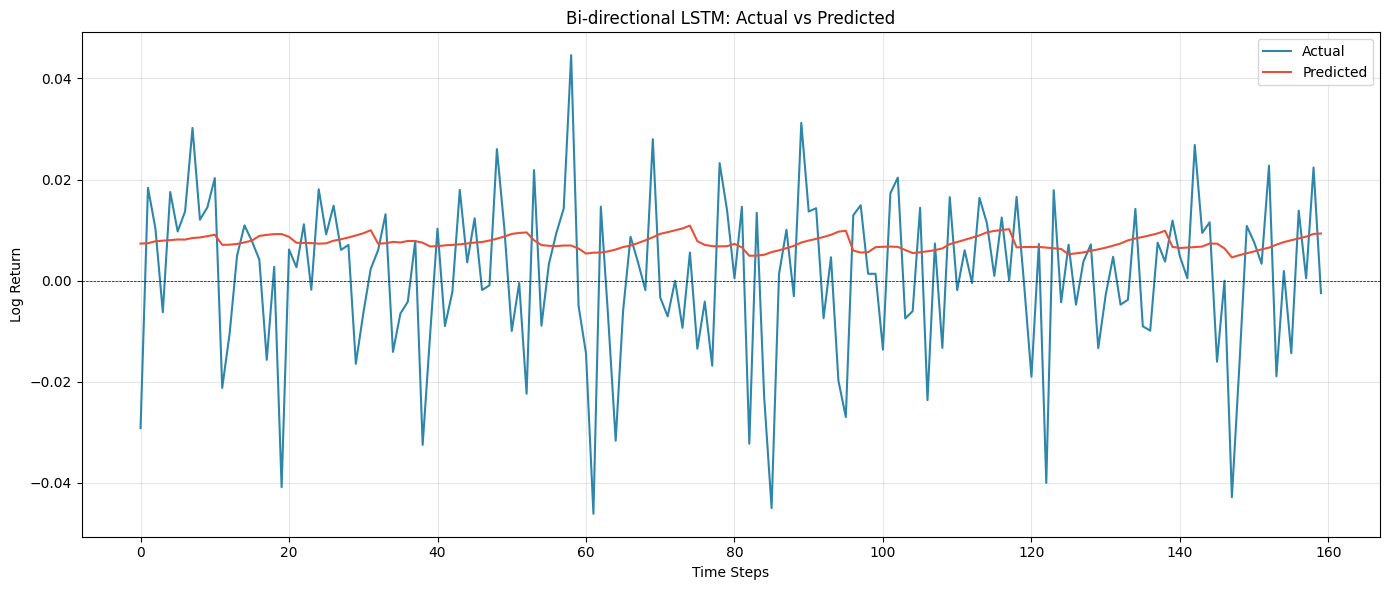

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(range(len(y_true_bilstm)), y_true_bilstm, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_bilstm)), y_pred_bilstm, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'Bi-directional LSTM: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

### Bi-directional LSTM + Attention

In [107]:
def build_bidir_lstm_attention_model(seq_length, n_features, lstm_units=64, dropout_rate=0.3):
    inputs = Input(shape=(seq_length, n_features))
    lstm_out = Bidirectional(LSTM(
        units=lstm_units,
        activation='tanh',
        return_sequences=True,
        recurrent_dropout=dropout_rate,
        kernel_regularizer=l2(1e-4),
        recurrent_regularizer=l2(1e-4)
    ))(inputs)
    
    context_vector = AttentionLayer(return_attention=False)(lstm_out)
    
    x = Dropout(dropout_rate)(context_vector)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

bilstm_att_model = build_bidir_lstm_attention_model(
    seq_length=X_train_seq.shape[1],
    n_features=X_train_seq.shape[2],
    lstm_units=64,
    dropout_rate=0.3
)

bilstm_att_model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
bilstm_att_model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 30, 31)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 30, 128)        │        49,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_8               │ (None, 128)            │        16,640 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,953 (273.25 KB)

 Trainable params: 69,953 (273.25 KB)

 Non-trainable params: 0 (0.00 B)

### Train Bi-directional LSTM + Attention Model

In [108]:
history_bilstm_att = bilstm_att_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]
)

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 29s 113ms/step - loss: 1.0870 - val_loss: 0.8602 - learning_rate: 1.0000e-04
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 1.0450 - val_loss: 0.8504 - learning_rate: 1.0000e-04
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 1.0486 - val_loss: 0.8400 - learning_rate: 1.0000e-04
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 1.0442 - val_loss: 0.8333 - learning_rate: 1.0000e-04
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 1.0361 - val_loss: 0.8350 - learning_rate: 1.0000e-04
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 1.0296 - val_loss: 0.8348 - learning_rate: 1.0000e-04
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 1.0292 - val_loss: 0.8346 - learning_rate: 1.0000e-04
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 1.0299 - val_loss: 0.8277 - learning_rate: 1.0000e-04
Epoch 9/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 1.0252 - 

In [109]:
y_pred_bilstm_att_scaled = bilstm_att_model.predict(X_test_seq).flatten()

y_pred_bilstm_att = target_scaler.inverse_transform(y_pred_bilstm_att_scaled.reshape(-1, 1)).flatten()
y_true_bilstm_att = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_bilstm_att = mean_squared_error(y_true_bilstm_att, y_pred_bilstm_att)
rmse_bilstm_att = np.sqrt(mse_bilstm_att)
mae_bilstm_att = mean_absolute_error(y_true_bilstm_att, y_pred_bilstm_att)

print(f"MSE:  {mse_bilstm_att:.6f}")
print(f"RMSE: {rmse_bilstm_att:.6f}")
print(f"MAE:  {mae_bilstm_att:.6f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
MSE:  0.000246
RMSE: 0.015669
MAE:  0.011983


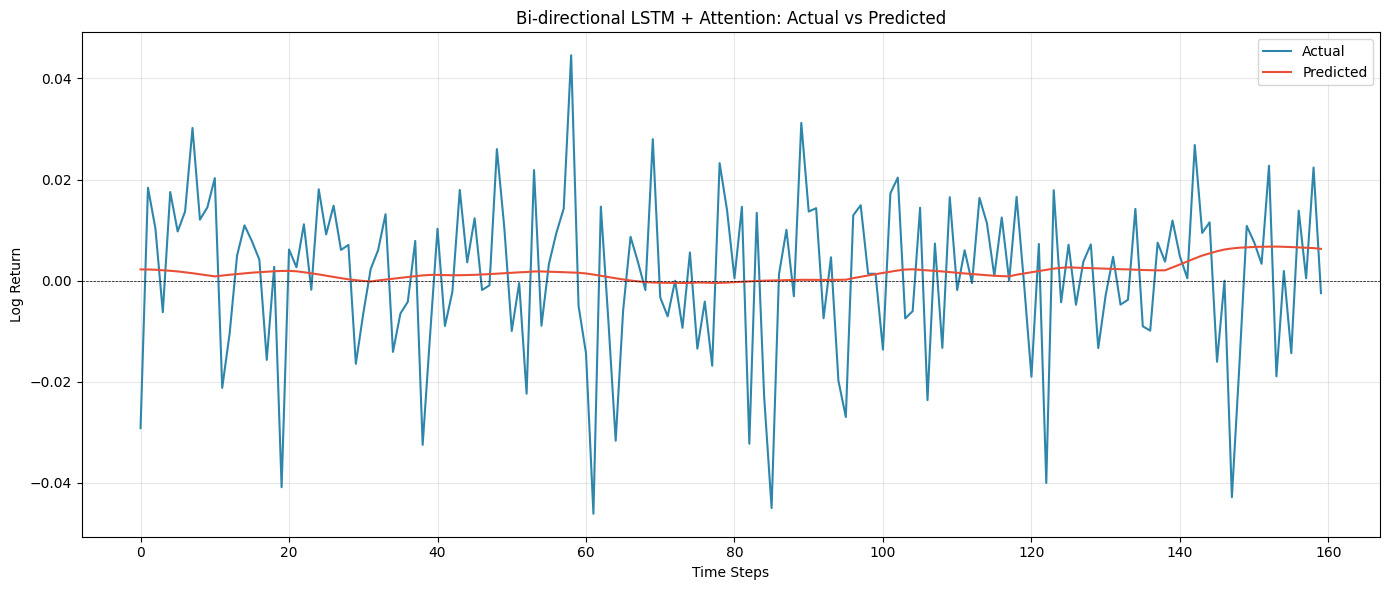

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(range(len(y_true_bilstm_att)), y_true_bilstm_att, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_bilstm_att)), y_pred_bilstm_att, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'Bi-directional LSTM + Attention: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

### Bi-directional LSTM + Attention + Skip Connections

In [111]:
def build_bidir_lstm_attention_skip_model(seq_length, n_features, lstm_units=64, dropout_rate=0.3):
    inputs = Input(shape=(seq_length, n_features))
    lstm_out = Bidirectional(LSTM(
        units=lstm_units,
        activation='tanh',
        return_sequences=True,
        recurrent_dropout=dropout_rate,
        kernel_regularizer=l2(1e-4),
        recurrent_regularizer=l2(1e-4)
    ))(inputs)
    
    context_vector = AttentionLayer(return_attention=False)(lstm_out)
    last_hidden = lstm_out[:, -1, :]
    
    gate_input = Concatenate()([context_vector, last_hidden])
    gate = Dense(lstm_units * 2, activation='sigmoid')(gate_input)
    gated_context = Multiply()([context_vector, Lambda(lambda x: 1.0 - x)(gate)])
    gated_residual = Multiply()([last_hidden, gate])
    
    combined = Add()([gated_context, gated_residual])
    skip_connection_output = LayerNormalization()(combined)
    
    x = Dropout(dropout_rate)(skip_connection_output)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

bilstm_skip_model = build_bidir_lstm_attention_skip_model(
    seq_length=X_train_seq.shape[1],
    n_features=X_train_seq.shape[2],
    lstm_units=64,
    dropout_rate=0.3
)

bilstm_skip_model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
bilstm_skip_model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 30, 31)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 30, 128)   │     49,152 │ input_layer_18[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_9   │ (None, 128)       │     16,640 │ bidirectional_9[… │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 128)       │          0 │ bidirectional_9[… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 256)       │          0 │ attention_layer_… │
│ (Concatenate)       │                   │            │ get_item_6[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 128)       │     32,896 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 128)       │          0 │ dense_34[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_12         │ (None, 128)       │          0 │ attention_layer_… │
│ (Multiply)          │                   │            │ lambda_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_13         │ (None, 128)       │          0 │ get_item_6[0][0], │
│ (Multiply)          │                   │            │ dense_34[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 128)       │          0 │ multiply_12[0][0… │
│                     │                   │            │ multiply_13[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 128)       │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 32)        │      4,128 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 32)        │          0 │ dense_35[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 1)         │         33 │ dropout_25[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 103,105 (402.75 KB)

 Trainable params: 103,105 (402.75 KB)

 Non-trainable params: 0 (0.00 B)

### Train Bi-directional LSTM + Attention + Skip Model

In [112]:
history_bilstm_skip = bilstm_skip_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]
)

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - loss: 2.1563 - val_loss: 2.5787 - learning_rate: 1.0000e-04
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - loss: 1.5361 - val_loss: 2.3041 - learning_rate: 1.0000e-04
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 1.3306 - val_loss: 2.1222 - learning_rate: 1.0000e-04
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 1.2472 - val_loss: 1.9252 - learning_rate: 1.0000e-04
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 1.1669 - val_loss: 1.7915 - learning_rate: 1.0000e-04
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 1.1247 - val_loss: 1.7152 - learning_rate: 1.0000e-04
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 1.0944 - val_loss: 1.6276 - learning_rate: 1.0000e-04
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 1.1045 - val_loss: 1.5984 - learning_rate: 1.0000e-04
Epoch 9/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 1.0675 - 

In [113]:
y_pred_bilstm_skip_scaled = bilstm_skip_model.predict(X_test_seq).flatten()

y_pred_bilstm_skip = target_scaler.inverse_transform(y_pred_bilstm_skip_scaled.reshape(-1, 1)).flatten()
y_true_bilstm_skip = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_bilstm_skip = mean_squared_error(y_true_bilstm_skip, y_pred_bilstm_skip)
rmse_bilstm_skip = np.sqrt(mse_bilstm_skip)
mae_bilstm_skip = mean_absolute_error(y_true_bilstm_skip, y_pred_bilstm_skip)

print(f"MSE:  {mse_bilstm_skip:.6f}")
print(f"RMSE: {rmse_bilstm_skip:.6f}")
print(f"MAE:  {mae_bilstm_skip:.6f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
MSE:  0.000743
RMSE: 0.027250
MAE:  0.024121


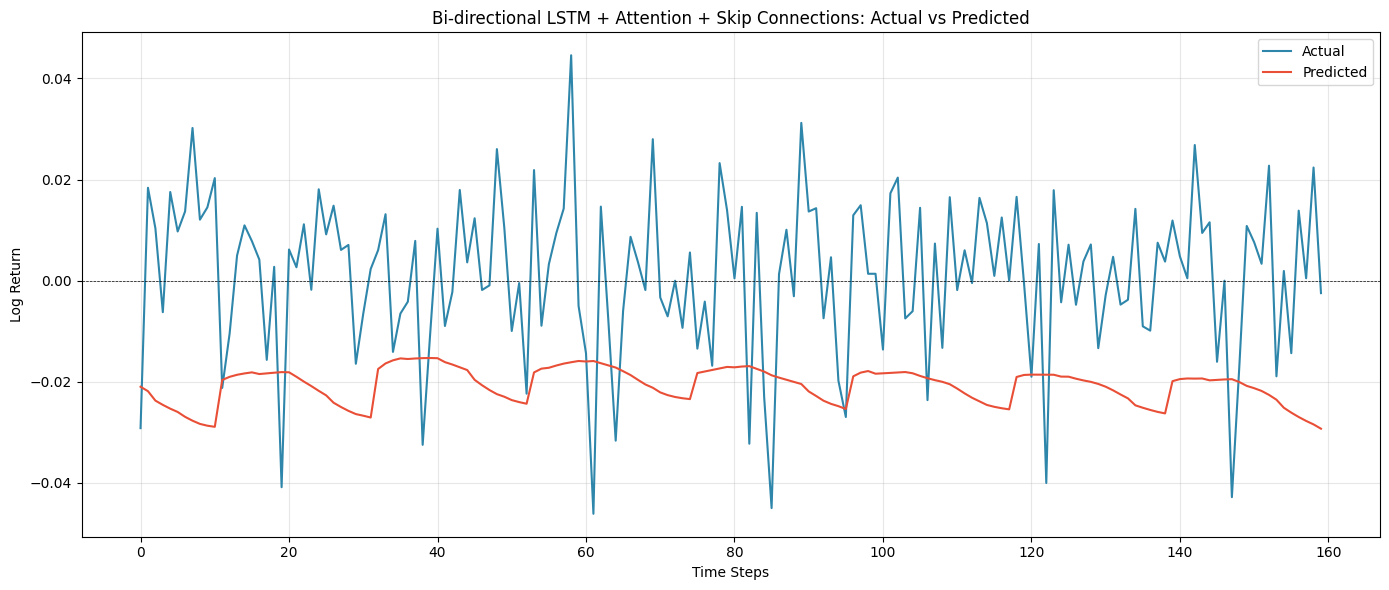

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(range(len(y_true_bilstm_skip)), y_true_bilstm_skip, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_bilstm_skip)), y_pred_bilstm_skip, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'Bi-directional LSTM + Attention + Skip Connections: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

### Final Model Comparison

               Model      MSE     RMSE      MAE
                 RNN 0.000634 0.025181 0.022064
          RNN + Attn 0.000637 0.025243 0.022136
   RNN + Attn + Skip 0.000242 0.015572 0.011941
               BiRNN 0.000322 0.017947 0.014489
        BiRNN + Attn 0.000274 0.016548 0.012294
 BiRNN + Attn + Skip 0.000636 0.025216 0.022051
                LSTM 0.000250 0.015813 0.011915
         LSTM + Attn 0.000242 0.015571 0.011968
  LSTM + Attn + Skip 0.000267 0.016341 0.012896
              BiLSTM 0.000281 0.016752 0.012580
       BiLSTM + Attn 0.000246 0.015669 0.011983
BiLSTM + Attn + Skip 0.000743 0.027250 0.024121


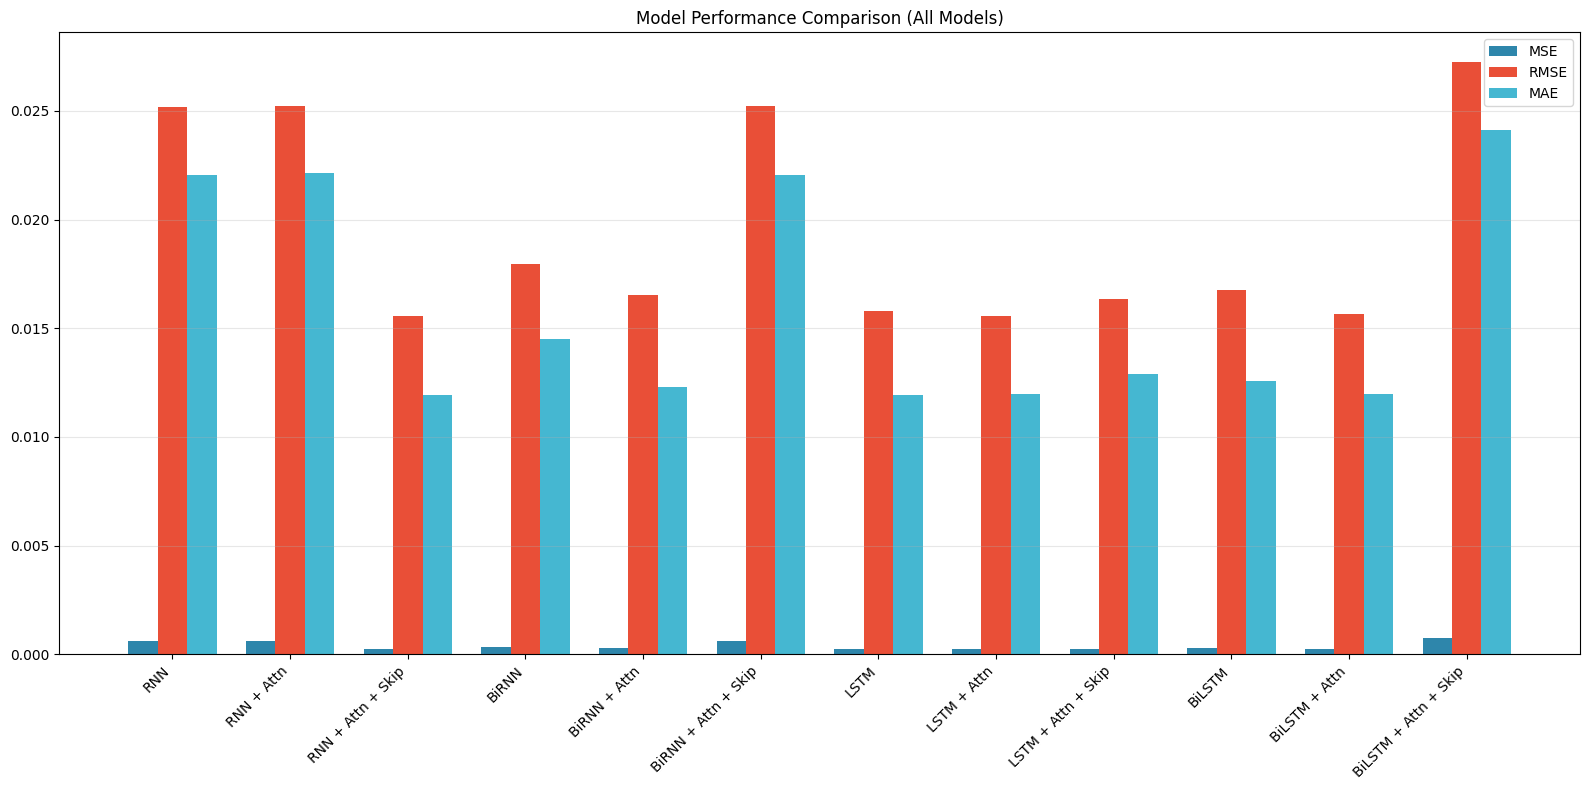

In [115]:
comparison_df = pd.DataFrame({
    'Model': ['RNN', 'RNN + Attn', 'RNN + Attn + Skip',
              'BiRNN', 'BiRNN + Attn', 'BiRNN + Attn + Skip',
              'LSTM', 'LSTM + Attn', 'LSTM + Attn + Skip',
              'BiLSTM', 'BiLSTM + Attn', 'BiLSTM + Attn + Skip'],
    'MSE': [mse, mse_att, mse_skip, mse_bidir, mse_bidir_att, mse_bidir_skip,
            mse_lstm, mse_lstm_att, mse_lstm_skip,
            mse_bilstm, mse_bilstm_att, mse_bilstm_skip],
    'RMSE': [rmse, rmse_att, rmse_skip, rmse_bidir, rmse_bidir_att, rmse_bidir_skip,
             rmse_lstm, rmse_lstm_att, rmse_lstm_skip,
             rmse_bilstm, rmse_bilstm_att, rmse_bilstm_skip],
    'MAE': [mae, mae_att, mae_skip, mae_bidir, mae_bidir_att, mae_bidir_skip,
            mae_lstm, mae_lstm_att, mae_lstm_skip,
            mae_bilstm, mae_bilstm_att, mae_bilstm_skip]
})

print(comparison_df.to_string(index=False))

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

x = np.arange(12)
width = 0.25

ax.bar(x - width, comparison_df['MSE'], width, label='MSE', color='#2E86AB')
ax.bar(x, comparison_df['RMSE'], width, label='RMSE', color='#E94F37')
ax.bar(x + width, comparison_df['MAE'], width, label='MAE', color='#45B7D1')

ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.set_title('Model Performance Comparison (All Models)')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Bi-directional LSTM Loss Comparison

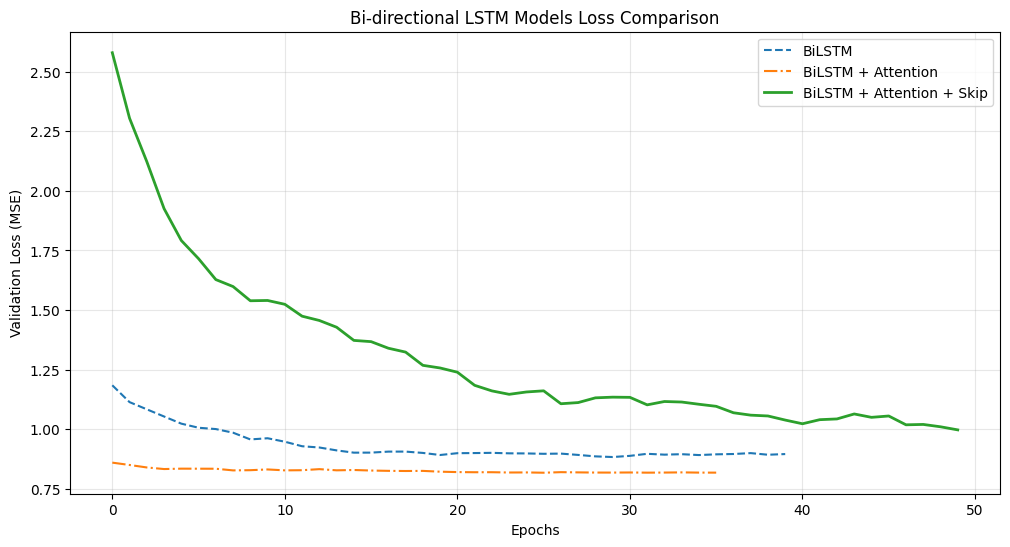

In [116]:
plt.figure(figsize=(12, 6))
plt.plot(history_bilstm.history['val_loss'], label='BiLSTM', linestyle='--')
plt.plot(history_bilstm_att.history['val_loss'], label='BiLSTM + Attention', linestyle='-.')
plt.plot(history_bilstm_skip.history['val_loss'], label='BiLSTM + Attention + Skip', linewidth=2)

plt.title('Bi-directional LSTM Models Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()